In [1]:
from __future__ import division
import sys, os, glob
import numpy as np
from scipy import stats
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import LambdaCDM
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib import pyplot as plt, rc
import h5py
import pandas as pd
import pickle
sys.path.insert(0, '/cosma5/data/dp004/dc-beck3/lib/')
import read_hdf5
sys.path.insert(0, '/cosma5/data/dp004/dc-beck3/StrongLensing/LensingMap/')
import LM_main_box
from LM_main_box import plant_Tree
sys.path.insert(0, '/cosma5/data/dp004/dc-beck3/StrongLensing/LensingPostProc/lib/')
import matching
import lens
import lpp_pyfuncs

/cosma5/data/dp004/dc-beck3/StrongLensing/LensingMap/LM_main_box.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/cosma/local/Python/2.7.15/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/cosma/local/Python/2.7.15/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/cosma/local/Python/2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/cosma/local/Python/2.7.15/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/cosma/local/Python/2.7.15/lib/python2.7/site-packages/ipykernel/ker

In [2]:
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 6      # major tick size in points
plt.rcParams['xtick.minor.size'] = 3      # minor tick size in points
plt.rcParams['xtick.major.width'] = 3    # major tick width in points
plt.rcParams['xtick.minor.width'] = 3    # minor tick width in points
plt.rcParams['ytick.major.size'] = 6      # major tick size in points
plt.rcParams['ytick.minor.size'] = 3      # minor tick size in points
plt.rcParams['ytick.major.width'] = 3    # major tick width in points
plt.rcParams['ytick.minor.width'] = 3    # minor tick width in points
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['lines.linewidth'] = 3

In [3]:
# Load Files
simname = ['F5', 'F6', 'GR']
snapnum = 39
simdir = '/cosma6/data/dp004/dc-arno1/SZ_project/full_physics/'\
         'L62_N512_%s_kpc/'
lmdir = '/cosma5/data/dp004/dc-beck3/StrongLensing/LensingMap/'\
        'full_physics/Subfind/L62_N512_%s_kpc/Box/LM_%s_zl020zs409.pickle'
hfdir = '/cosma6/data/dp004/dc-arno1/SZ_project/full_physics/'\
        'L62_N512_%s_kpc/'
lppdir = '/cosma5/data/dp004/dc-beck3/StrongLensing/LensingPostProc/'\
         'full_physics/Subfind/Box/LPPBox_%s_lens_zl020zs409.h5'

iPTF16geu = {'Rein' : 1.05,                              #[arcsec]
             'Mein' : np.array([1.7*1e10, 0.06, 0.06]),  #[Msol]
             'Vrms' : np.array([163, 41, 27]),           #[km/s]
             'e' : np.array([0.15, 0.07, 0.07]),         # Ellipticity
             'mu' : 52}

## Subhalo Properties

In [18]:
for ff in range(len(simname)):
    lppfile = lppdir % simname[ff]
    
    # Subhalo Data
    if simname[ff] == 'F5':
        lenses_f5 = pd.read_hdf(lppfile)
    elif simname[ff] == 'F6':
        lenses_f6 = pd.read_hdf(lppfile)
    elif simname[ff] == 'GR':
        lenses_gr = pd.read_hdf(lppfile)

print(lenses_f5.columns.values)
print(len(lenses_f5.index.values),
      len(lenses_f6.index.values),
      len(lenses_gr.index.values))

['Mass' 'Npart' 'Rstellarhalfmass' 'Vrms' 'offset' 'Pos' 'Vel' 'ZL' 'Rein'
 'ZS' 'Nimg' 'FOV' 'theta' 'delta_t' 'mu' 'Mlens' 'Ellipticity'
 'Prolateness' 'VelProfRad' 'VelProfMeas' 'VrmsProfRad' 'VrmsProfMeas'
 'DensProfRad' 'DensProfMeas' 'SMProfRad' 'SMProfMeas' 'SCVProfRad'
 'SCVProfMeas']
(24, 19, 72)


# Mass

/cosma/local/Python/2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/cosma/local/Python/2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


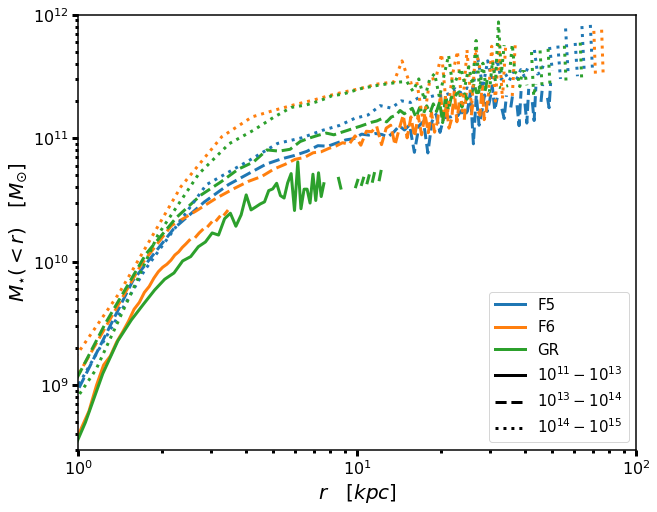

In [9]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
lower = [1e11, 1e13, 1e14]
upper = [1e13, 1e14, 1e15]

lstyle = ['-', '--', ':']
plt.loglog()
for ll in range(3):

    for ss in range(len(simname)):
        if simname[ss] == 'GR':
            lenses = lenses_gr[
                ['SMProfRad','SMProfMeas']][(lenses_gr['Mass'] > lower[ll]) & (upper[ll] > lenses_gr['Mass'])]
        elif simname[ss] == 'F6':
            lenses = lenses_f6[
                ['SMProfRad','SMProfMeas']][(lenses_f6['Mass'] > lower[ll]) & (upper[ll] > lenses_f6['Mass'])]
        elif simname[ss] == 'F5':
            lenses = lenses_f5[
                ['SMProfRad','SMProfMeas']][(lenses_f5['Mass'] > lower[ll]) & (upper[ll] > lenses_f5['Mass'])]

        radius = pd.DataFrame(
            lenses['SMProfRad'].values.tolist(),
            columns=np.arange(len(lenses['SMProfRad'].values[0])))
        measurement = pd.DataFrame(
            lenses['SMProfMeas'].values.tolist(),
            columns=np.arange(len(lenses['SMProfMeas'].values[0])))

        #for ll in range(len(lenses.index.values)):
        #    radius = radius.replace(0, np.nan)
        #    plt.plot(radius.iloc[ll], measurement.iloc[ll], color=colors[ss], alpha=0.3)

        rad = radius.as_matrix(columns=None)
        meas = measurement.as_matrix(columns=None)
        rad = rad.flatten()
        meas = meas.flatten()
        indx = np.argsort(rad)
        meas = meas[indx]
        rad = rad[indx]
        meas = meas[~np.isnan(rad)]
        rad = rad[~np.isnan(rad)]

        binmean, binedg, binnum = stats.binned_statistic(
            rad, meas, statistic='median', bins=100)
        bin_width = (binedg[1] - binedg[0])
        bincenters = binedg[1:] - bin_width/2

        plt.plot(bincenters, binmean, color=colors[ss],
                 linestyle=lstyle[ll])

f5label = mlines.Line2D([], [], c=colors[0],
                         linestyle='-', label='F5')
f6label = mlines.Line2D([], [], c=colors[1],
                         linestyle='-', label='F6')
grlabel = mlines.Line2D([], [], c=colors[2],
                         linestyle='-', label='GR')
massbin1 = mlines.Line2D([], [], c='k',
                         linestyle=lstyle[0],
                         label=r'$10^{11}-10^{13}$')
massbin2 = mlines.Line2D([], [], c='k',
                         linestyle=lstyle[1],
                         label=r'$10^{13}-10^{14}$')
massbin3 = mlines.Line2D([], [], c='k',
                         linestyle=lstyle[2],
                         label=r'$10^{14}-10^{15}$')

plt.xlim(1e0, 1e2)
plt.ylim(3e8, 1e12)
plt.xlabel(r'$r \quad [kpc]$')
plt.ylabel(r'$M_{\star}(<r) \quad [M_{\odot}]$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.legend(loc=4, handles=[f5label, f6label, grlabel,
                           massbin1, massbin2, massbin3])
plt.savefig('MassProfile.png',
            bbox_inches='tight')

# Circular Velocity

/cosma/local/Python/2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/cosma/local/Python/2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


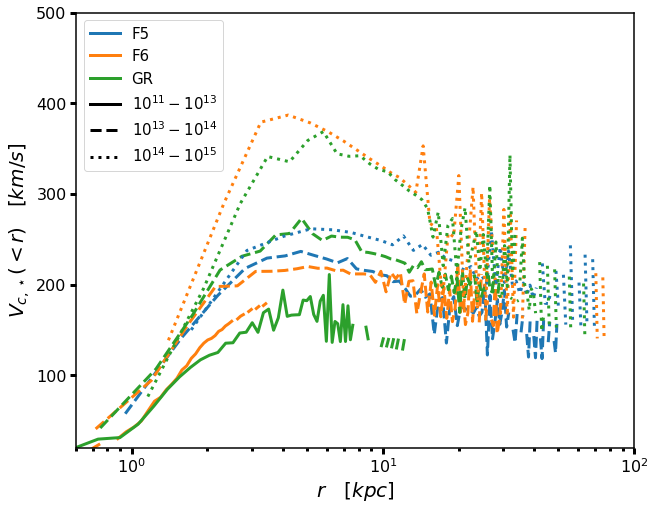

In [16]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
lower = [1e11, 1e13, 1e14]
upper = [1e13, 1e14, 1e15]

lstyle = ['-', '--', ':']
plt.xscale('log')
for ll in range(3):

    for ss in range(len(simname)):
        if simname[ss] == 'GR':
            lenses = lenses_gr[
                ['SCVProfRad','SCVProfMeas']][(lenses_gr['Mass'] > lower[ll]) & (upper[ll] > lenses_gr['Mass'])]
        elif simname[ss] == 'F6':
            lenses = lenses_f6[
                ['SCVProfRad','SCVProfMeas']][(lenses_f6['Mass'] > lower[ll]) & (upper[ll] > lenses_f6['Mass'])]
        elif simname[ss] == 'F5':
            lenses = lenses_f5[
                ['SCVProfRad','SCVProfMeas']][(lenses_f5['Mass'] > lower[ll]) & (upper[ll] > lenses_f5['Mass'])]

        radius = pd.DataFrame(
            lenses['SCVProfRad'].values.tolist(),
            columns=np.arange(len(lenses['SCVProfRad'].values[0])))
        measurement = pd.DataFrame(
            lenses['SCVProfMeas'].values.tolist(),
            columns=np.arange(len(lenses['SCVProfMeas'].values[0])))

        rad = radius.as_matrix(columns=None)
        meas = measurement.as_matrix(columns=None)
        rad = rad.flatten()
        meas = meas.flatten()
        indx = np.argsort(rad)
        meas = meas[indx]
        rad = rad[indx]
        meas = meas[~np.isnan(rad)]
        rad = rad[~np.isnan(rad)]

        binmean, binedg, binnum = stats.binned_statistic(
            rad, meas, statistic='median', bins=100)
        bin_width = (binedg[1] - binedg[0])
        bincenters = binedg[1:] - bin_width/2

        plt.plot(bincenters, binmean, color=colors[ss],
                 linestyle=lstyle[ll])

f5label = mlines.Line2D([], [], c=colors[0],
                         linestyle='-', label='F5')
f6label = mlines.Line2D([], [], c=colors[1],
                         linestyle='-', label='F6')
grlabel = mlines.Line2D([], [], c=colors[2],
                         linestyle='-', label='GR')
massbin1 = mlines.Line2D([], [], c='k',
                         linestyle=lstyle[0],
                         label=r'$10^{11}-10^{13}$')
massbin2 = mlines.Line2D([], [], c='k',
                         linestyle=lstyle[1],
                         label=r'$10^{13}-10^{14}$')
massbin3 = mlines.Line2D([], [], c='k',
                         linestyle=lstyle[2],
                         label=r'$10^{14}-10^{15}$')

plt.xlim(6e-1, 1e2)
plt.ylim(2e1, 5e2)
plt.xlabel(r'$r \quad [kpc]$')
plt.ylabel(r'$V_{c, \star}(<r) \quad [km/s]$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.legend(loc=2, handles=[f5label, f6label, grlabel,
                           massbin1, massbin2, massbin3])
plt.savefig('CircVelocityProfile.png',
            bbox_inches='tight')

# Density

/cosma/local/Python/2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/cosma/local/Python/2.7.15/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


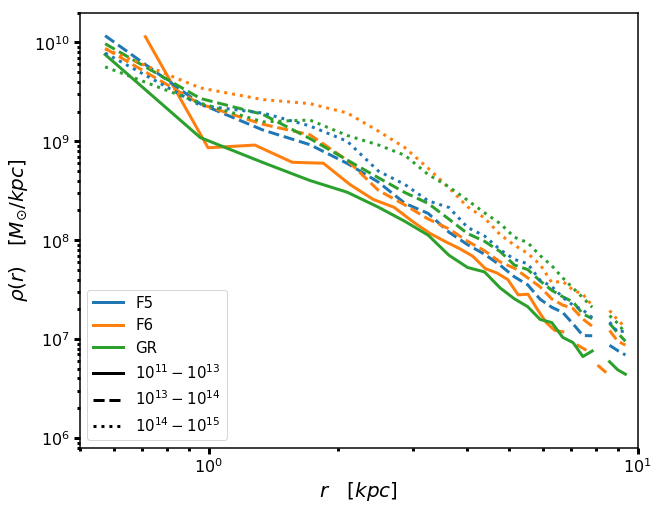

In [13]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
lower = [1e11, 1e13, 1e14]
upper = [1e13, 1e14, 1e15]

lstyle = ['-', '--', ':']
plt.loglog()
for ll in range(3):

    for ss in range(len(simname)):
        if simname[ss] == 'GR':
            lenses = lenses_gr[
                ['DensProfRad','DensProfMeas']][(lenses_gr['Mass'] > lower[ll]) & (upper[ll] > lenses_gr['Mass'])]
        elif simname[ss] == 'F6':
            lenses = lenses_f6[
                ['DensProfRad','DensProfMeas']][(lenses_f6['Mass'] > lower[ll]) & (upper[ll] > lenses_f6['Mass'])]
        elif simname[ss] == 'F5':
            lenses = lenses_f5[
                ['DensProfRad','DensProfMeas']][(lenses_f5['Mass'] > lower[ll]) & (upper[ll] > lenses_f5['Mass'])]

        radius = pd.DataFrame(
            lenses['DensProfRad'].values.tolist(),
            columns=np.arange(len(lenses['DensProfRad'].values[0])))
        measurement = pd.DataFrame(
            lenses['DensProfMeas'].values.tolist(),
            columns=np.arange(len(lenses['DensProfMeas'].values[0])))

        rad = radius.as_matrix(columns=None)
        meas = measurement.as_matrix(columns=None)
        rad = rad.flatten()
        meas = meas.flatten()
        indx = np.argsort(rad)
        meas = meas[indx]
        rad = rad[indx]
        meas = meas[~np.isnan(rad)]
        rad = rad[~np.isnan(rad)]

        binmean, binedg, binnum = stats.binned_statistic(
            rad, meas, statistic='median', bins=100)
        bin_width = (binedg[1] - binedg[0])
        bincenters = binedg[1:] - bin_width/2
        bincenters = bincenters[binmean != 0.]
        binmean = binmean[binmean != 0.]

        plt.plot(bincenters, binmean, color=colors[ss],
                 linestyle=lstyle[ll])

f5label = mlines.Line2D([], [], c=colors[0],
                         linestyle='-', label='F5')
f6label = mlines.Line2D([], [], c=colors[1],
                         linestyle='-', label='F6')
grlabel = mlines.Line2D([], [], c=colors[2],
                         linestyle='-', label='GR')
massbin1 = mlines.Line2D([], [], c='k',
                         linestyle=lstyle[0],
                         label=r'$10^{11}-10^{13}$')
massbin2 = mlines.Line2D([], [], c='k',
                         linestyle=lstyle[1],
                         label=r'$10^{13}-10^{14}$')
massbin3 = mlines.Line2D([], [], c='k',
                         linestyle=lstyle[2],
                         label=r'$10^{14}-10^{15}$')

plt.xlim(5e-1, 1e1)
plt.ylim(8e5, 2e10)
plt.xlabel(r'$r \quad [kpc]$')
plt.ylabel(r'$\rho(r) \quad [M_{\odot}/kpc]$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.legend(loc=3, handles=[f5label, f6label, grlabel,
                           massbin1, massbin2, massbin3])
plt.savefig('DensityProfile.png',
            bbox_inches='tight')